# Lab 4 Pre-lab: Introduction to Digital Communications
#### Written by Miki Lustig
_Updated by Josh Sanz, Spring 2022_

In this pre-lab you will be introduced to several modes of digital communications. We have written the solutions for you. However, you are more than welcome to comment the cells and implement the solutions yourself. 

## Analog Modulation
In analog communications we encode continuous valued signals on top of a carrier frequency. Information can be encoded in the amplitude, e.g. amplitude modulation (AM) or single sideband (SSB), encoded in the phase, e.g. phase modulation or frequency modulation or encoded in both phase and amplitude. One of the issues with analog modulation is that you can never get the signal you are transmitting exactly recovered. It will always be contaminated by system imperfections, noise, and other deviations. 
At the same time, analog communication offers simple implementations as well as robustness because signals often degrade gracefully and information can still be extracted from them even with severe interferences and low signal to-noise-ratio.

## Digital Modulation
In contrast, in digital communications we transmit quantized digital data. Because the information is digital, this form of communications offers the advantage of a perfect reproduction of the transmitted signal. Much like analog communications, digital data can be encoded in many different ways using phase, amplitude, and frequency. It can be encoded using a binary stream in which '0' and '1' _bits_ are transmitted in each time interval. It can also be encoded with M-ary symbols, in which higher order _symbols_ are transmitted in each time interval. A 4-ary symbol can take 4 different values {0, 1, 2, 3}, so each symbol can represent 2 bits {00, 01, 10, 11}. In this case, the bit rate is twice the symbol rate.


In [47]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal
from numpy.fft import fft
from lab4functions import avgPS, myspectrogram_hann_ovlp
%matplotlib inline


## Examples of different digital modulations:

In the following sections we will consider signals with a symbol rate of 300 baud* with a carrier frequency of 1800 Hz and a sampling rate of 48000 Hz. Each symbol will correspond to 48000/300 = 160 samples. The carrier frequency was chosen such that there are exactly 6 cycles in a symbol -- this is useful for the phase-based modulation schemes where we would like to have a continuous phase. 

\**A symbol/second is called a baud. You may have heard your parents talk about old 9600 baud modems.*

In [33]:
fs = 48000  # sampling rate
baud = 300  # symbol rate
Nsyms = 256  # number of symbols
Ns = int(fs//baud)  # samples per symbol
N = int(Nsyms * Ns) # number of samples
f0 = 1800 # center frequency

Ndisp = 16 # number of symbols to display
np.random.seed(seed=2021)
syms = np.random.randn(Nsyms,1) > 0 # generate random symbols

### Amplitude-Shift Keying (ASK) or On-Off Keying (OOK) 
ASK/OOK encodes digital data in the amplitude of the carrier, $M(t)\cos(2\pi f_0t)$ where $M(t) = \{0~or~1\}$ for binary data. We have previously seen an example of this in the ADS-B lab. M-ary digital data can also be encoded in the amplitude by allowing more amplitude levels. For example $M(t) = \{0~or~0.33~or~0.66~or~1.0\}$ for a 4-ary symbol. 

Here's an example of an OOK signal:

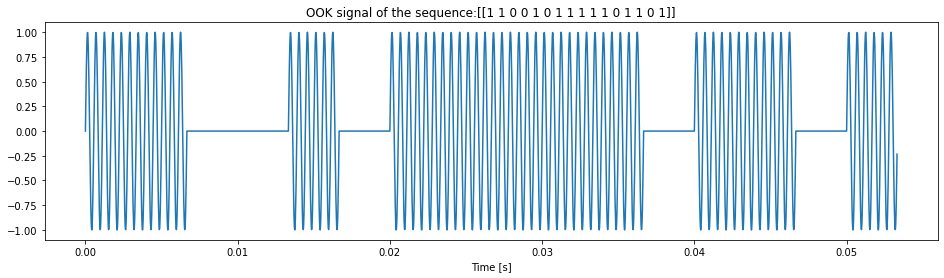

In [34]:
# create an impulse signal
message = np.zeros(N)
message[::Ns] = syms.ravel()

# convolve with a rect
h = np.ones(Ns)
message = signal.convolve(message,h,mode='full')

# modulate
t = r_[0.0:len(message)]/fs
OOK = message*sin(2*pi*f0*t)

fig = plt.figure(figsize = (16,4))
plt.plot(t[:Ndisp*Ns],OOK[:Ndisp*Ns])
plt.xlabel('Time [s]')
plt.title('OOK signal of the sequence:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))));

The approach of using OOK/ASK as above is not ideal. We can see this by plotting the spectrum with the provided `avgPS` function. The function signature of `avgPS` is

    (freqs, power_spectrum) = avgPS(signal, N=window_size, fs=sampling_freq)
    
* **Compute the average power spectrum of the above OOK signal using the provided function `avgPS`**, and plot its magnitude.


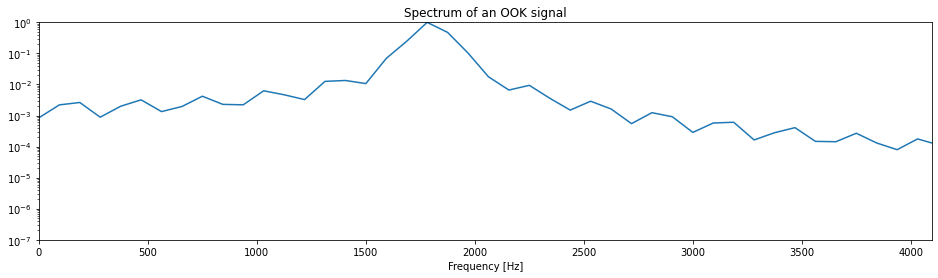

In [35]:
(f,OOK_f) = avgPS(OOK,512,fs)  #todoline

fig = plt.figure(figsize = (16,4))
plt.semilogy(f, OOK_f / max(OOK_f))
plt.xlabel('Frequency [Hz]')
plt.title('Spectrum of an OOK signal')
plt.axis((0,4096,1e-7,1));

#### Question: Comment on the spectrum. What is the issue that may arise if one would like to transmit at nearby frequencies?

#### Your answer here:
Because of the sharp transitions between "On" and "Off", the signal is not very narrowband. There is a lot of spectral leakage that could interfere with transmissions at nearby frequencies.
______

### Pulse Shaping
Instead of using rectangular pulses, we can use shaped pulses which have a more narrowband frequency response. This is called _pulse shaping_. For example, we could filter using a sinc-based pulse that would result in a bandlimited spectrum. This is refered to as a _pulse shaping filter_. Of course, it is not practical to use a sinc since it is infinite in length. Instead we can use truncated (windowed) sinc pulses with certain time-bandwidth (TBW) product that would be finite in length and narrowband. While we use windowed sinc functions here (as shown in class), the communications community often uses the *raised cosine filter* instead. A raised cosine is a tapered sinc function (with parameter $0\leq \beta \leq 1$) for which the impulse response and spectrum looks like\*:

<figure>
    <table>
        <tr>
            <td><img src="./1200px-Raised-cosine-impulse.svg.png" style="width: 470px; float: left" ></td>
            <td><img src="./1200px-Raised-cosine_filter.svg.png" style="width: 470px; float: right" ></td>
        </tr>
    </table>
    <center>
        <figcaption>
            Figure 1: Raised-Cosine Pulse Shaping
        </figcaption>
    </center>
</figure>


\*For more information about the raised cosine function look [here](http://www.commsys.isy.liu.se/TSKS04/lectures/3/MichaelZoltowski_SquareRootRaisedCosine.pdf)

The time-bandwidth product is a poorly-defined rule-of-thumb metric for signals that encapsulates both temporal and spectral resolution. In this lab, we will define the TBW for a finite-length signal as the product of its time support and its frequency full-width at half-maximum (FWHM). By this definition, the TBW of a rectangular pulse is approximately 1 (closer to 1.2). For comparison, the TBW of a Hamming window is ~1.8 and the TBW of a Hann window is ~2.0.  

* **Using the random symbol sequence `syms` generated above, create a new sequence of all zeros except for discrete impulses spaced apart by the _symbol period_.** The symbol period is the length between adjacent symbols (in samples). For example, a sequence of '1010' would have an impulse at position 0, an impulse at position 320, and zeros elsewhere.
* **Generate a TBW=4 windowed sinc pulse with zero-crossings occuring every 160 samples.** 
* **Convolve the sinc with the impulse train** to generate a pulse-shaped OOK/ASK signal. 
* **Modulate the result to 1800 Hz.**
* **Plot the signal and its spectrum.**

*Image sources: http://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Raised-cosine-impulse.svg/1200px-Raised-cosine-impulse.svg.png and http://upload.wikimedia.org/wikipedia/commons/thumb/a/a1/Raised-cosine_filter.svg/1200px-Raised-cosine_filter.svg.png

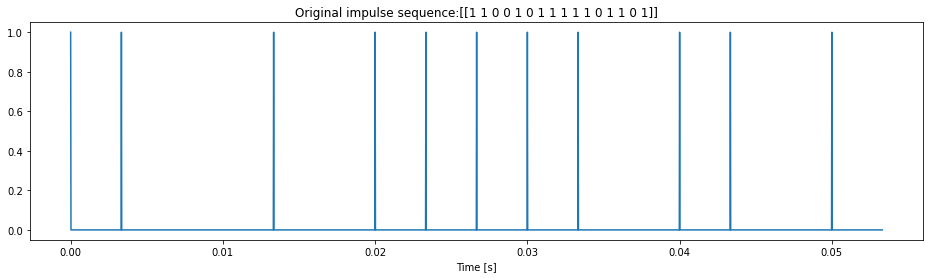

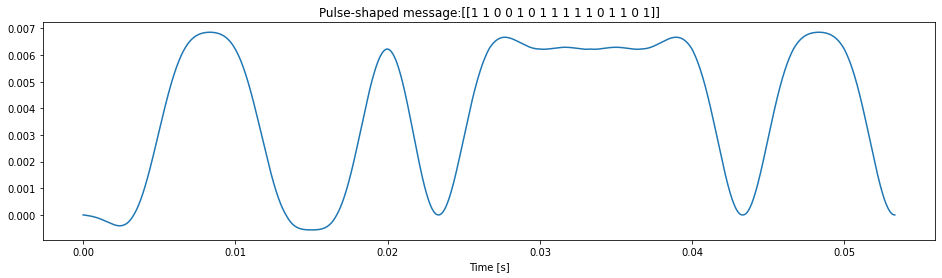

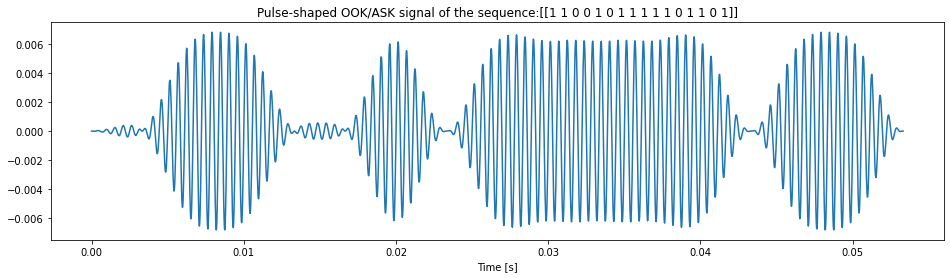

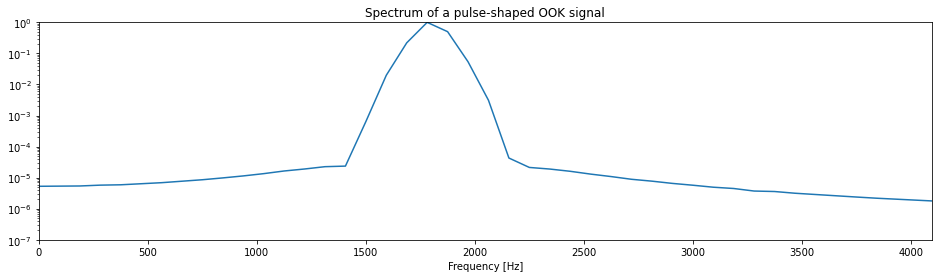

In [36]:
message = zeros(N)
message[::Ns] = syms.ravel()

# Your code here:

# pulse-shaping filter
h = signal.firwin(Ns * 4, 1.0 / Ns) # Hamming windowed sinc

# smooth message with pulse-shaping filter, h
message_s = signal.convolve(message, h, mode='full')

# modulate
t = r_[0.0:len(message_s)] / fs
OOK_s = message_s * sin(2 * pi * f0 * t)

(f,OOK_sf) = avgPS(OOK_s, 512, fs)

# Plot
fig = plt.figure(figsize = (16, 4))
plt.plot(t[:Ndisp * Ns], message[:Ndisp * Ns])
plt.xlabel('Time [s]')
plt.title('Original impulse sequence:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))))

fig = plt.figure(figsize = (16, 4))
plt.plot(t[:Ndisp * Ns], message_s[:Ndisp * Ns])
plt.xlabel('Time [s]')
plt.title('Pulse-shaped message:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))))

fig2 = plt.figure(figsize = (16, 4))
plt.plot(t[:Ndisp * Ns], OOK_s[:Ndisp * Ns])
plt.xlabel('Time [s]')
plt.title('Pulse-shaped OOK/ASK signal of the sequence:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))))

fig3 = plt.figure(figsize = (16, 4))
plt.semilogy(f, abs(OOK_sf) / max(abs(OOK_sf)))
plt.xlabel('Frequency [Hz]')
plt.title('Spectrum of a pulse-shaped OOK signal')
plt.axis((0, 4096, 1e-7, 1));

#### Question: Comment on the separation between on and off.... what happened? Comment on the spectrum.

#### Your answer here:
The envelope has been smoothed out by the pulse-shaping filter so the AM signal is more bandlimited.
______

### Phase-Shift Keying (PSK) 
PSK encodes digital data in the phase of the signal.  For example, Binary PSK (BPSK) sends a stream of '0's and '1's by alternating the sign of the carrier in each bit period: $Real \left \{ e^{j\pi M(t)}\cos(2\pi f_0t) \right \}$, where $M(t)$ is a signal of $\{0~or~1\}$ corresponding to '0's and '1's. The RBDS subcarrier in FM radio is BPSK encoded. Also, [PSK31](http://en.wikipedia.org/wiki/PSK31) is a very popular text-to-text ham radio protocol for HF that has 31 bit/s rate, which matches a typical keyboard typing rate. An M-ary symbol can be transmitted by MPSK in which $M(t)$ are broken to smaller intervals. For example, in 4-PSK (a.k.a. QPSK), the symbols {0, 1, 2, 3} are encoded in $M(t) = \{0~or~0.5~or~1~or~1.5\}$. They could also be encoded in a $45^\circ$ rotated constellation using $M(t) = \{0.25~or~0.75~or~1.25~or~1.75\}$.

Here's an example of a BPSK signal:

Text(0.5, 1.0, 'BPSK signal of the sequence:[[1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1]]')

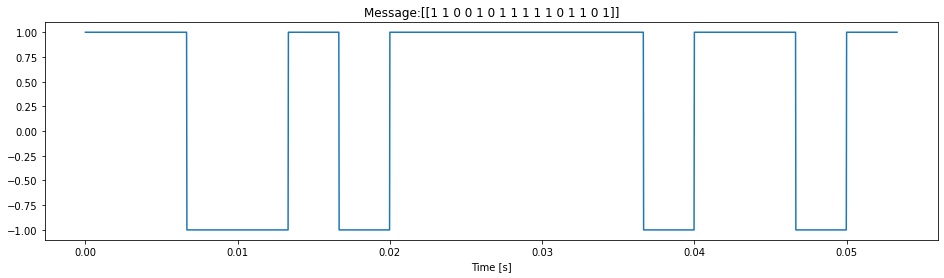

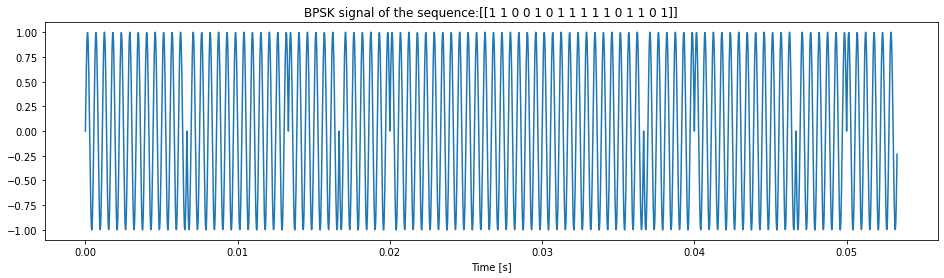

In [37]:
message = zeros(N)
message[::Ns] = 2*syms.ravel() - 1 # makes the message +/- 1

# Convolve with rect
h = np.ones(Ns)
message = signal.convolve(message,h,mode='full')

# modulate
t = r_[0.0:len(message)]/fs
BPSK = message*sin(2*pi*f0*t)

# Plot
fig = plt.figure(figsize = (16,4))
plt.plot(t[:Ns*Ndisp],message[:Ns*Ndisp])
plt.xlabel('Time [s]')
plt.title('Message:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))))

fig = plt.figure(figsize = (16,4))
plt.plot(t[:Ns*Ndisp],BPSK[:Ns*Ndisp])
plt.xlabel('Time [s]')
plt.title('BPSK signal of the sequence:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))))

One of the advantages of PSK is that the envelope of the signal is constant. This means that we don't have to use linear amplifiers (also called class A or AB) in order to amplify the signal for transmission. Instead we can use the much more efficient non-linear amplifiers (class C or E). However, the problem is of course that the phase has discontinuities. This will have an effect on the spectrum. 

* **Compute the spectrum of the above BPSK signal.** Comment on the spectrum.

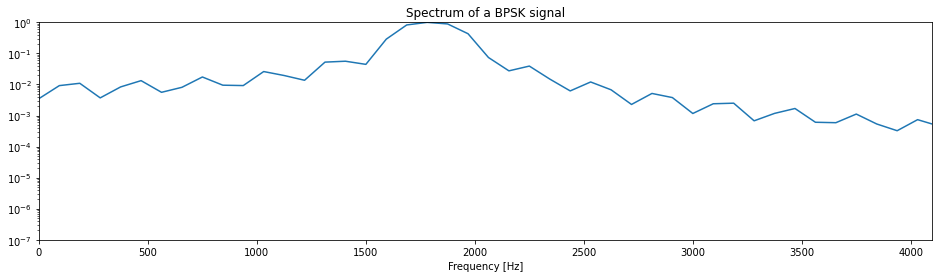

In [38]:
(f,BPSK_f) = avgPS(BPSK,512,fs)  #todoline

fig = plt.figure(figsize = (16,4))
plt.semilogy(f,abs(BPSK_f)/max(BPSK_f))
plt.xlabel('Frequency [Hz]')
plt.title('Spectrum of a BPSK signal')
plt.axis((0,4096,1e-7,1));

#### Your comments here:
The spectrum of the BPSK signal is not very spectrally efficient. In other words, the spectrum does not decay quickly away from the main lobe.
____

We can use the same "trick" as before and shape the pulses with a windowed sinc filter. 

* **Repeat the procedure used previously on shaped ASK/OOK for the case of BPSK.** However, instead of a zero-one pulse train use a $\pm 1$ train to get the changes in phase. 

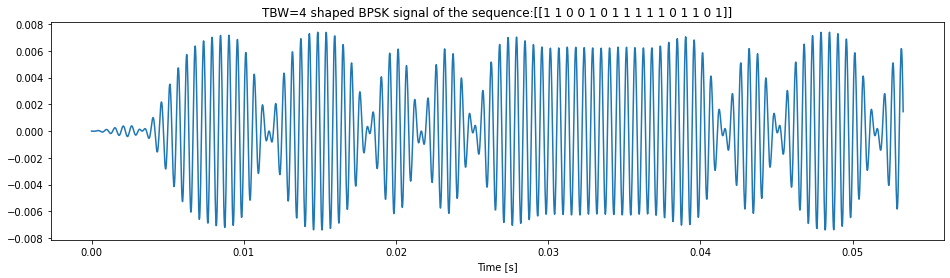

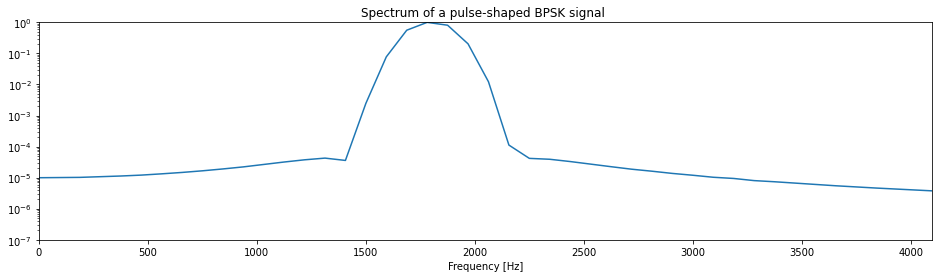

In [39]:
message = zeros(N)
message[::Ns] = 2*syms.ravel() - 1

# Repeat the computation of the BPSK signal, but use the trick from before to to shape the pulses.
# Your final signal should be called BPSK_s.

# Your code here:

# pulse-shaping filter
h = signal.firwin(Ns*4,1.0/Ns)
message_s = signal.convolve(message,h,mode='full')

# modulate
t = r_[0.0:len(message_s)]/fs
BPSK_s = message_s*sin(2*pi*f0*t)

# Plot
fig = plt.figure(figsize = (16,4))
plt.plot(t[:Ndisp*Ns],BPSK_s[:Ndisp*Ns])
plt.xlabel('Time [s]')
plt.title('TBW=4 shaped BPSK signal of the sequence:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))))

(f,BPSK_sf) = avgPS(BPSK_s,512,fs)

fig = plt.figure(figsize = (16,4))
plt.semilogy(f,abs(BPSK_sf)/max(BPSK_sf))
plt.xlabel('Frequency [Hz]')
plt.title('Spectrum of a pulse-shaped BPSK signal ')
plt.axis((0,4096,1e-7,1));

#### Question: What did we win and what did we lose? Comment on the spectrum, the inter-symbol interference, and the envelope of the signal. 

#### Your answer here:
The spectrum is more bandlimited after filtering, which is good for spectral efficiency. However, the envelope is no longer constant so we lose the efficiency of nonlinear amplifiers. We may also experience more inter-symbol interference.
____

### Quadrature-Amplitude Modulation (QAM)
QAM encodes M-ary digital data in both the amplitude and phase, i.e., $Real \left \{ M(t)\exp(2\pi f_0t) \right \}$ where $M(t)$ takes values on a _constellation_ in the complex plane. An M-ary constellation is a set of M points in the complex plane used for encoding M different symbols. QAM is heavily used in cable TV and modems, and indirectly in WiFI and cell signals. For example, the constellations of QAM-16 and QAM-256 divide the complex plane to $4\times 4$ and $16\times 16$ grids, respectively. 
 
Here's an image of the constellation of QAM-16, which encodes the symbols {0, 1, ..., 15} a.k.a. {0, 1, ..., F} in hexadecimal format:
<center><img src="./QAM16.png" style="width: 350px;"/></center>
<center>Figure 2: QAM-16 Constellation</center>


An example of 16QAM is shown below:

Text(0.5, 1.0, 'QAM-16 of the sequence:[[ 9 11  2  5 15  2  2 12 10 12  1  0 15  9  1  8]]')

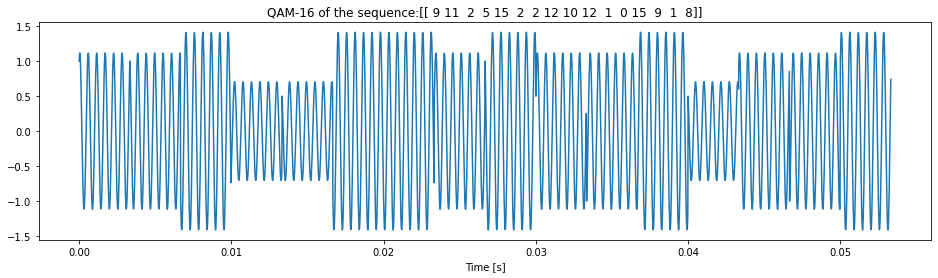

In [40]:
# code = {2: -2+2j, 6: -1+2j, 14: 1+2j, 10: 2+2j,
#         3: -2+1j, 7: -1-1j, 15: 1+1j, 11: 2+1j,
#         1: -2-1j, 5: -1-1j, 13: 1-1j, 9:  2-1j,
#         0: -2-2j, 4: -1-2j, 12: 1-2j, 8:  2-2j}
Nsyms = 16 # number of symbols
N = Nsyms * Ns
code = np.array((-2-2j, -2-1j,-2+2j,-2+1j,-1-2j,-1-1j,-1+2j,-1+1j,+2-2j,+2-1j,+2+2j,+2+1j,1-2j,+1-1j,1+2j,1+1j)) / 2.
np.random.seed(2021)
syms = np.uint16(np.random.rand(Nsyms,1)*16)

message = zeros(N, dtype='complex')
message[::Ns] = code[syms].ravel()

# convolve with rect
h = np.ones(Ns)
message = signal.convolve(message,h,mode='full')

# modulate
t = r_[0.0:len(message)]/fs
QAM = np.real(message*exp(1j*2*pi*f0*t))

fig = plt.figure(figsize = (16,4))
plt.plot(t[:Ns*Ndisp],QAM[:Ns*Ndisp])
plt.xlabel('Time [s]')
plt.title("QAM-16 of the sequence:"+ np.array2string(np.transpose(syms[:Ndisp])))

QAM is a very efficient way to use the amplitude as well as the phase to encode M-ary symbols. 

* **Compute the spectrum of the above QAM-16 signal.**
* **Repeat the same pulse shaping procedure with the TBW=4 pulse from earlier.**


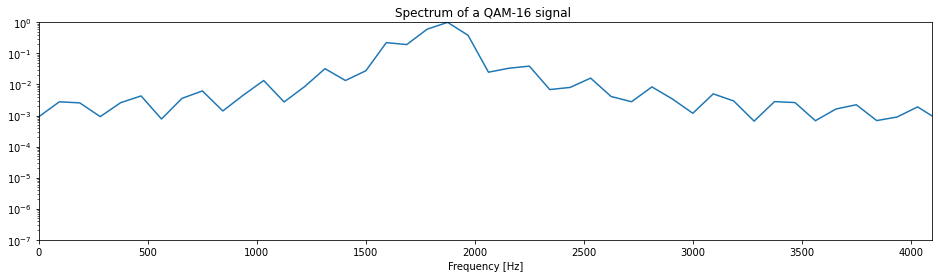

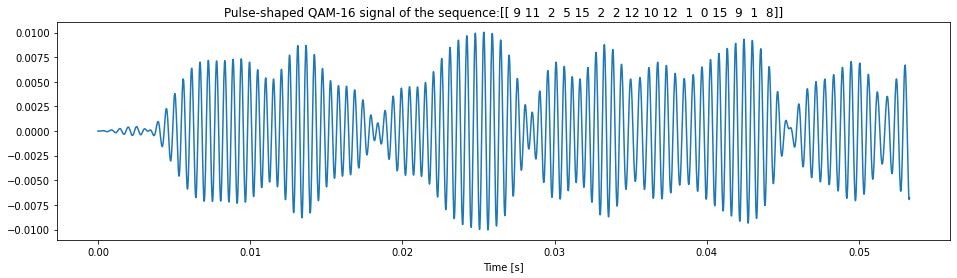

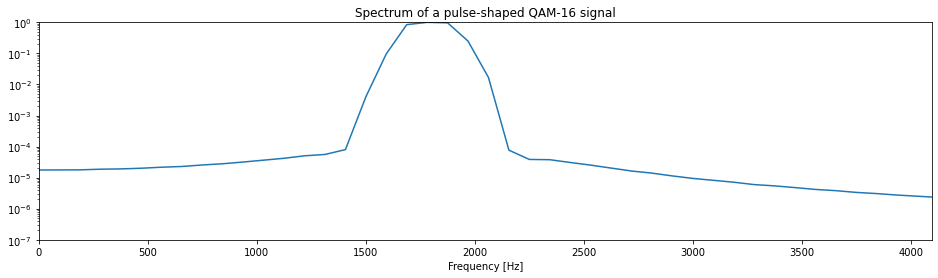

In [41]:
message = zeros(N,dtype='complex')
message[::Ns] = code[syms].ravel()
(f,QAM_f) = avgPS(QAM,512,fs)

# Your code here:

# pulse-shaping filter
h = signal.firwin(Ns*4,1.0/Ns)
message = signal.convolve(message,h,mode='full')

# modulate
t = r_[0.0:len(message)]/fs
QAM_s = np.real(message*exp(1j*2*pi*f0*t))

(f,QAM_sf) = avgPS(QAM_s,512,fs)

# Plot
fig = plt.figure(figsize = (16,4))
plt.semilogy(f,QAM_f/max(QAM_f))
plt.xlabel('Frequency [Hz]')
plt.title('Spectrum of a QAM-16 signal ')
plt.axis((0,4096,1e-7,1))

fig = plt.figure(figsize = (16,4))
plt.plot(t[:Ns*Ndisp],QAM_s[:Ns*Ndisp])
plt.xlabel('Time [s]')
plt.title('Pulse-shaped QAM-16 signal of the sequence:'+ np.array2string(np.transpose(syms[:Ndisp])))

fig = plt.figure(figsize = (16,4))
plt.semilogy(f,QAM_sf/max(QAM_sf))
plt.xlabel('Frequency [Hz]')
plt.title('Spectrum of a pulse-shaped QAM-16 signal')
plt.axis((0,4096,1e-7,1));

#### Question: Is the bandwidth much different than the binary sequences? What is the bitrate improvement per bandwidth you get? 

#### Your answers here:
The bandwidth is about the same as BPSK, but we get 4 bits per symbol instead of 1. Therefore, we get a 4X bitrate improvement per bandwidth.
____

### Frequency-Shift Keying (FSK)
FSK encodes digital data in the frequency of the carrier, i.e., $\cos \left(2\pi (f_0 + M(t)\Delta f)t\right)$. For Binary FSK (BFSK),  $M(t) =\{1~or~-1\}$. In M-ary FSK (MFSK) the total bandwidth can be divided into more segments. Again, like PSK, FSK has a constant envelope which makes it ideal for use with efficient non-linear amplifiers. 

The choice of frequencies has a huge impact on the signal's bandwidth and our ability to demodulate it. For example, we would like the frequencies to be orthogonal over a symbol period so that a correlation detector will produce the maximum difference between the results. We would also like the phase to be continuous for the sidelobes to decay rapidly and not interfere with nearby channels.  

For example, the choice of frequencies of $\{1200~\text{Hz}, 2400~\text{Hz}\}$ below for a symbol rate of 300 baud results in 4 and 8 cycles per symbol period, respectively. The outcome is a smooth phase and orthogonal frequencies.

An example is show below:

Text(0.5, 1.0, 'FSK signal of the sequence:[[1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1]]')

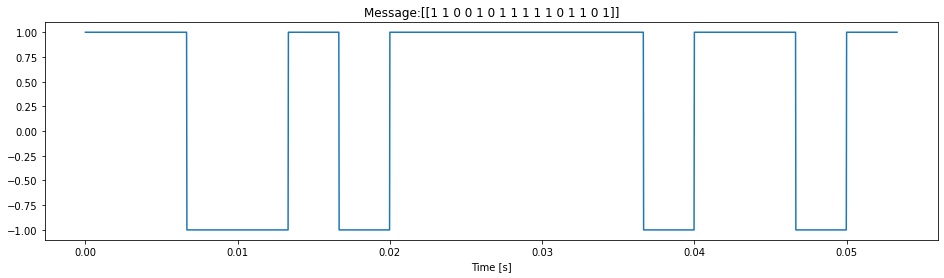

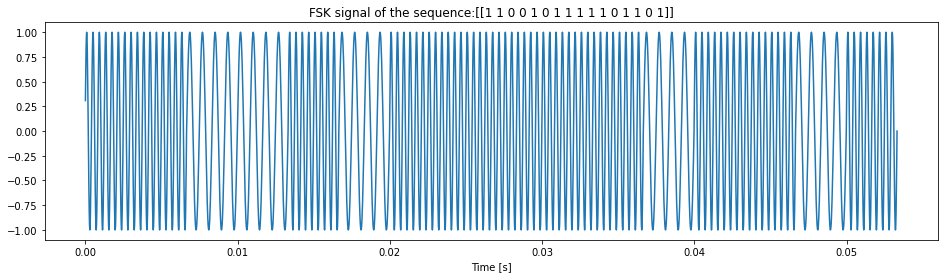

In [42]:
np.random.seed(2021)
syms = np.random.randn(Nsyms,1) > 0 # generate random symbols
message = zeros(N)
message[::Ns] = 2*syms.ravel() - 1

# convolve with rect
h = np.ones(Ns)
message = signal.convolve(message,h,mode='full')

# compute phase by integrating frequency
delta_f = 600
ph = 2*pi*np.cumsum(f0 + message*delta_f)/fs
t = r_[0.0:N]/fs
FSK = sin(ph)

# Plot
fig = plt.figure(figsize = (16,4))
plt.plot(t[:Ns*Ndisp],message.ravel()[:Ns*Ndisp])
plt.xlabel('Time [s]')
plt.title('Message:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))))

fig = plt.figure(figsize = (16,4))
plt.plot(t[:Ns*Ndisp],FSK[:Ns*Ndisp])
plt.xlabel('Time [s]')
plt.title('FSK signal of the sequence:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))))

* **Compute the spectrum of the above FSK signal.** Can you see the frequencies?


(0.0, 4096.0, 1e-07, 1.0)

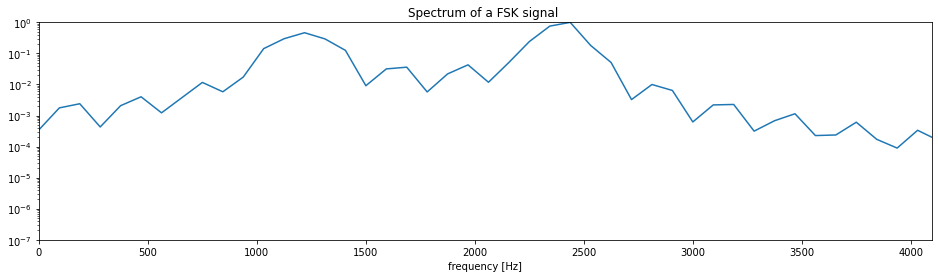

In [43]:
(f,FSK_f) = avgPS(FSK,512,fs)  #todoline

fig = plt.figure(figsize = (16,4))
plt.semilogy(f,FSK_f/max(FSK_f))
plt.xlabel('frequency [Hz]')
plt.title('Spectrum of a FSK signal ')
plt.axis((0,4096,1e-7,1))

The reason the frequencies are separated well is the low bit-rate.
For the same choice of frequencies we can increase the symbol rate and still get continuous phase and orthogonal frequencies. For example: at 600 baud we will get 2 cycles for 1200 Hz and 4 cycles for 2400 Hz per symbol period. We can continue further to 1200 baud, which results in 1 cycle/2 cycle for 1200 Hz/2400 Hz. 

Finally, the highest rate at which we can get orthogonal frequencies is 2400 baud. In that case, we will have 1/2 a cycle for 1200 Hz and 1 cycle for 2400 Hz. The phase will still be continuous and the frequencies orthogonal. This form of FSK modulation is also called Minimum Shift Keying (MSK) and is generally the case when the frequency difference between the high and low frequencies of BFSK is half the symbol rate.

* **What would be the choice of frequencies for a 300 baud MSK centered at 1800 Hz?**
* **Generate the MSK-300 modulation of the above signal.**
* **Plot the signal as well as its spectrum and spectrogram.** For the spectrogram, use 160 for the window length (which is the symbol period). Comment on the bandwidth of the signal compared to the BFSK above.

1


(0.0, 0.05, 0.0, 5000.0)

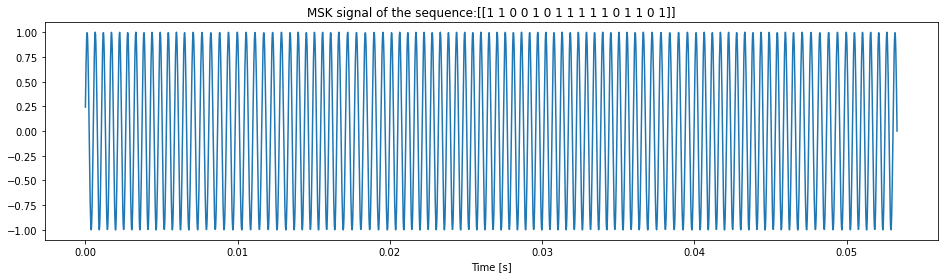

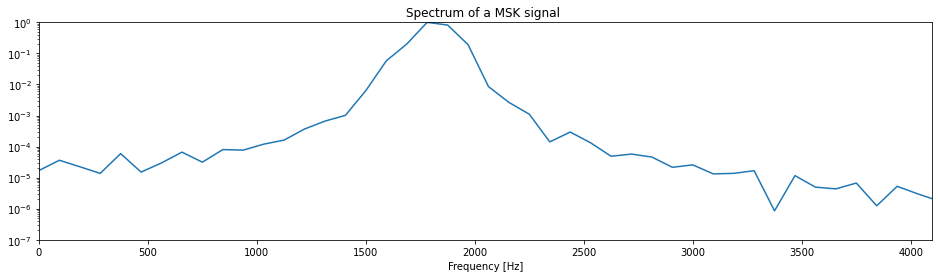

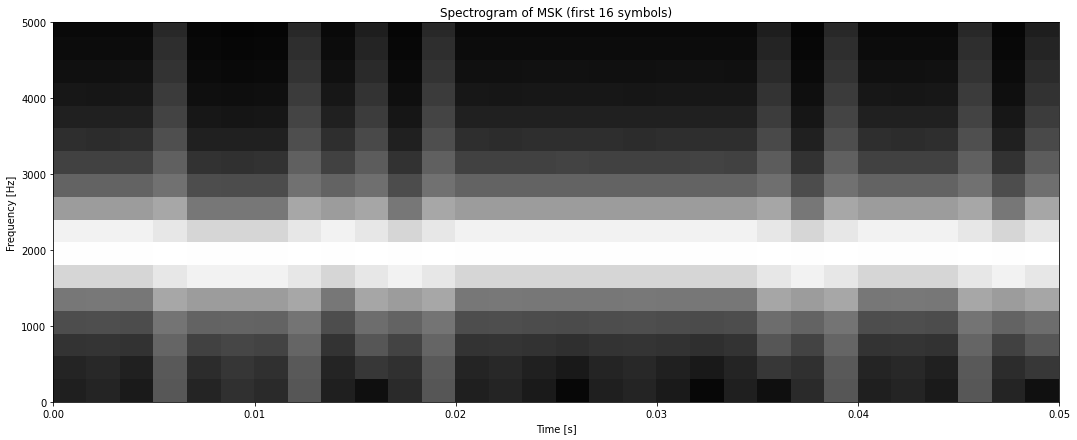

In [48]:
# Your code here:
delta_f = 75
ph = 2*pi*np.cumsum(f0 + message*delta_f)/fs
t = r_[0.0:N]/fs
MSK = sin(ph)

(f,MSK_f) = avgPS(MSK,512,fs)

# Plot
fig = plt.figure(figsize = (16,4))
plt.plot(t[:Ns*Ndisp],MSK[:Ns*Ndisp])
plt.xlabel('Time [s]')
plt.title('MSK signal of the sequence:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))))

fig = plt.figure(figsize = (16,4))
plt.semilogy(f,MSK_f/max(MSK_f))
plt.xlabel('Frequency [Hz]')
plt.title('Spectrum of a MSK signal ')
plt.axis((0,4096,1e-7,1))

tt,ff,xmf = myspectrogram_hann_ovlp(MSK[:Ns*Ndisp], 160, 48000.0, 0, dbf=30)
plt.title('Spectrogram of MSK (first 16 symbols)')
plt.axis((0, .05, 0, 5000))

#### Comment on the bandwidth of the signal compared to the FSK above:

#### Your comments here:
Compared to the previous FSK signal, the bandwidth is much lower. This makes sense because the two frequencies used are much closer together.
____

MSK is a very efficient modulation with constant envelope and a narrow bandwidth. However its sidelobes are still prohibitively high for applications like cellphone networks. The sidelobes can be further reduced by prefiltering the instantaneous frequency transitions by a smoothing filter. A very common filter is a Gaussian filter. When a Gaussian filter is used, the modulation is called GMSK. This is the modulation that is used for GSM networks. Much like the other modulations, filtering reduces the sidelobes, but increases the inter-symbol interference. 

The Gaussian filter used in GMSK is defined as:
$$ h(t) = \sqrt{\frac{2\pi}{\mathrm{log} 2}} \cdot TBW \mathrm{exp}\left(-\frac{2\pi^2(BW)^2}{\mathrm{log}2}t^2\right), $$ 
where BW (bandwidth) is determined by the time-bandwidth product (TBW) and symbol period $T_b$ with $BW = \frac{TBW}{T_b}$.

* **Generate a TBW=1 Gaussian filter with a span of 2 symbols.** What is the bandwidth in Hz?
* **Plot the filter.**
* **Filter the instantaneous frequency of the MSK signal above using the Gaussian filter.** Integrate to generate the phase of the modulated signal as above.
* **Plot the signal and its spectrum.**

In [49]:
def gaussfilt(Ns, TBW=0.5, span=2):
    # Ns is the number of samples per symbol period
    # TBW is the time-bandwidth product
    # span is the number of symbol periods to evaluate over
    L = span*Ns + 1
    t = np.linspace(-span/2, span/2, L)
    h = sqrt(2*pi/log(2)) * TBW*exp(-2*pi**2/log(2) * TBW**2 * t**2)
    return h/h.sum()

1


Text(0.5, 1.0, 'Spectrogram of GMSK')

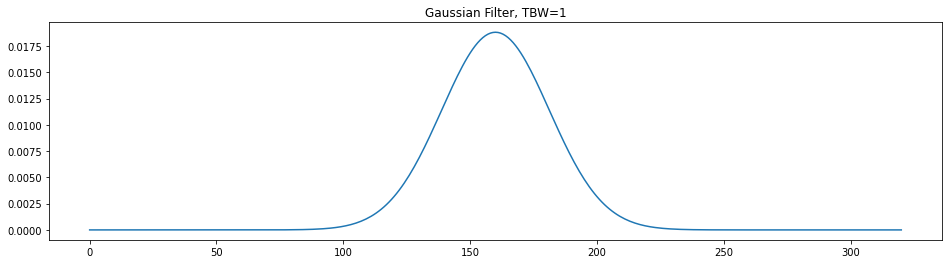

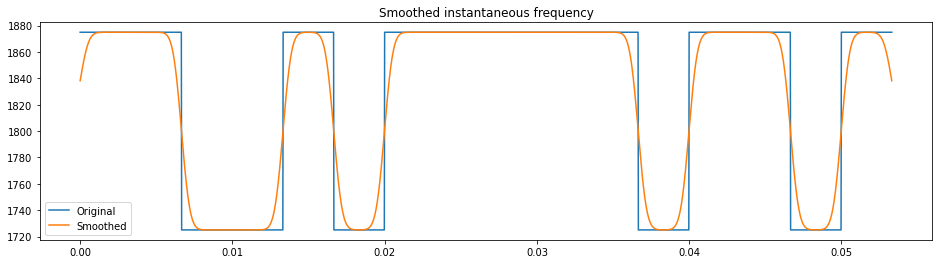

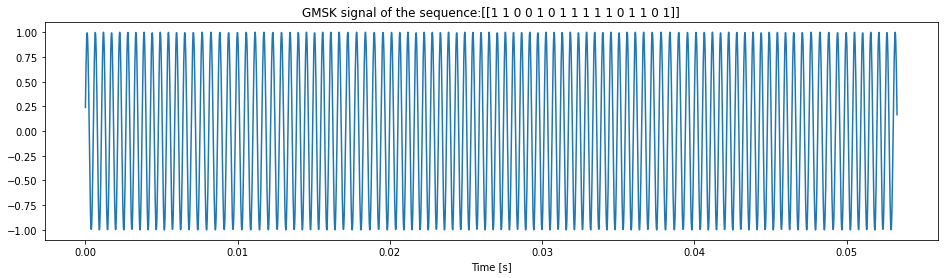

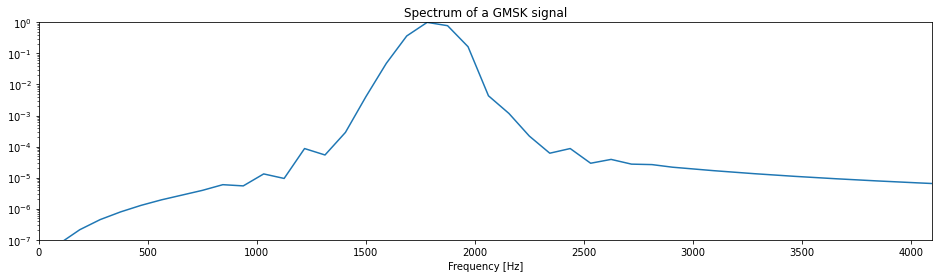

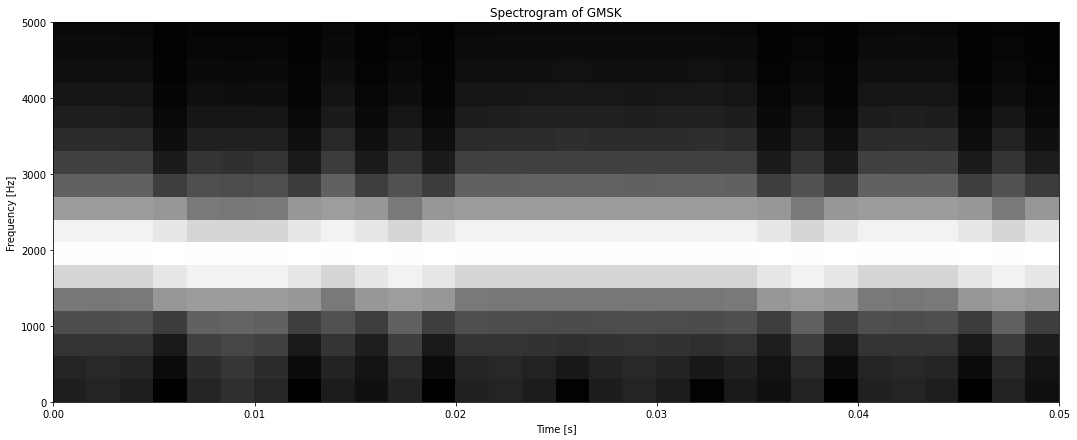

In [51]:
message = zeros(N)
message[::Ns] = 2*syms.ravel() - 1

# convolve with rect
h = np.ones(Ns)
message = signal.convolve(message,h,mode='full')

# Your code here:

# convolve with Gaussian filter
TBW = 1.
span = 2
h = gaussfilt(Ns, TBW, span)
message_s = signal.convolve(message,h,'same') # smoothed message

ph = 2*pi*np.cumsum(f0 + message_s*delta_f)/fs

GMSK = sin(ph)

t = r_[0.0:len(GMSK)]/fs


fig = plt.figure(figsize=(16,4))
plt.plot(h)
plt.title("Gaussian Filter, TBW=1")

fig = plt.figure(figsize=(16,4))
plt.plot(t[:Ns*Ndisp],f0 + delta_f*message[:Ns*Ndisp])
plt.plot(t[:Ns*Ndisp],f0 + delta_f*message_s[:Ns*Ndisp])
plt.title('Smoothed instantaneous frequency')
plt.legend(['Original','Smoothed'])

fig = plt.figure(figsize = (16,4))
plt.plot(t[:Ns*Ndisp],GMSK[:Ns*Ndisp])
plt.xlabel('Time [s]')
plt.title('GMSK signal of the sequence:'+ np.array2string(np.transpose(np.uint8(syms[:Ndisp]))))

(f,GMSK_f) = avgPS(GMSK[Ns:-Ns],512,fs)

fig = plt.figure(figsize = (16,4))
plt.semilogy(f,GMSK_f/max(GMSK_f))
plt.xlabel('Frequency [Hz]')
plt.title('Spectrum of a GMSK signal')
plt.axis((0,4096,1e-7,1))

tt,ff,xmf = myspectrogram_hann_ovlp(GMSK[:Ns*Ndisp], 160, 48000.0, 0, dbf=30)
plt.axis((0, .05, 0, 5000))
plt.title(f'Spectrogram of GMSK')

#### Comment on the result. Does the spectrum have lower sidelobes? Explain why the spectrum looks this way and compare to the spectrogram.  

#### Your comments here:
The sidelobes have indeed decreased. This is because the instantaneous frequency has been smoothed out by the Gaussian filter so the time-domain signal is smoother. The spectrogram still shows the frequency changing over time, but with much fewer artifacts than the previous non-filtered MSK spectrogram.
____